In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import threshold
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
import spacy
from torch.nn.utils.rnn import pad_sequence
import os


In [49]:
class Vocabulary:
    def __init__(self, frequency_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.frequency_threshold = frequency_threshold
        self.spacy_eng = spacy.load("en_core_web_sm")

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        return [tok.text.lower() for tok in self.spacy_eng.tokenizer(str(text))]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] = frequencies.get(word, 0) + 1
        for word, count in frequencies.items():
            if count >= self.frequency_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word

                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [50]:
class FlickerDataset(Dataset):
    def __init__(self, root_dir, caption_file, vocab, transform=None):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        self.vocab = vocab
        self.images = self.df["images"]
        self.captions = self.df["captions"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        caption = self.captions[index]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized_caption)


In [51]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [52]:
# This class will be used by the DataLoader to pad captions
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        captions = [item[1] for item in batch]

        images = torch.cat(images, dim=0)
        captions = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)

        return images, captions

In [53]:
import pandas as pd

df = pd.read_csv("cleaned_results.csv")  # Tell pandas to split on '|'
df.columns = df.columns.str.strip()  # Remove extra spaces from column names

In [54]:
threshold=10
vocab=Vocabulary(10)

In [55]:
dataset = FlickerDataset(

    root_dir=r"C:\Users\swaya\Desktop\Timepass\python\IMAGE_WORD\flickr30k_images",
    caption_file="cleaned_results.csv",
    vocab=vocab,
    transform=image_transforms
)

In [56]:
captions_list=df["captions"]

In [57]:
vocab.build_vocabulary(captions_list)
pad_idx = vocab.stoi["<PAD>"]

In [58]:
vocab.stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 ' ': 4,
 'two': 5,
 'young': 6,
 'guys': 7,
 'with': 8,
 'shaggy': 9,
 'hair': 10,
 'look': 11,
 'at': 12,
 'their': 13,
 'hands': 14,
 'while': 15,
 'hanging': 16,
 'out': 17,
 'in': 18,
 'the': 19,
 'yard': 20,
 '.': 21,
 ',': 22,
 'white': 23,
 'males': 24,
 'are': 25,
 'outside': 26,
 'near': 27,
 'many': 28,
 'bushes': 29,
 'men': 30,
 'green': 31,
 'shirts': 32,
 'standing': 33,
 'a': 34,
 'man': 35,
 'blue': 36,
 'shirt': 37,
 'garden': 38,
 'friends': 39,
 'enjoy': 40,
 'time': 41,
 'together': 42,
 'several': 43,
 'hard': 44,
 'hats': 45,
 'operating': 46,
 'giant': 47,
 'pulley': 48,
 'system': 49,
 'workers': 50,
 'down': 51,
 'from': 52,
 'up': 53,
 'above': 54,
 'on': 55,
 'piece': 56,
 'of': 57,
 'equipment': 58,
 'working': 59,
 'machine': 60,
 'wearing': 61,
 'four': 62,
 'top': 63,
 'tall': 64,
 'structure': 65,
 'three': 66,
 'large': 67,
 'rig': 68,
 'child': 69,
 'pink': 70,
 'dress': 71,
 'is': 72,
 'climbing': 7

In [59]:
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # so we are using the resnet and telling it to load the orignal weights it has been trained , because it is traind on a lot of image and it is good at detecting features

        for param in resnet.parameters():
            param.requires_grad_(False)
            # do not update the weights

        modules = list(resnet.children())[:-1]
        # list of all the architucture expect the final layer

        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images) #feed into -> (batch_size,2058(festures),1,1)
        features = features.view(features.size(0), -1) # -> (batch_size, 2058)

        features = self.fc(features)  # because the fc inputs the 2d vactor

        return features

In [60]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])

        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        hiddens, _ = self.lstm(embeddings)

        outputs = self.linear(hiddens)

        return outputs

In [61]:

df = pd.read_csv("cleaned_results.csv")
df.columns = df.columns.str.strip()
captions_list = df["captions"].dropna().astype(str).tolist()


vocab = Vocabulary(10)
vocab.build_vocabulary(captions_list)
pad_idx = vocab.stoi["<PAD>"]

dataset = FlickerDataset(
    root_dir=r"C:\Users\swaya\Desktop\Timepass\python\IMAGE_WORD\flickr30k_images",
    caption_file="cleaned_results.csv",
    vocab=vocab,
    transform=image_transforms
)

data_loader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=MyCollate(pad_idx=pad_idx)
)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")


Training on device: cuda


In [63]:
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
num_layers = 3
learning_rate = 0.0001
num_epochs = 20


In [64]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])

params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

print("Starting training...")
encoder.train()
decoder.train()

Starting training...


DecoderRNN(
  (embed): Embedding(5461, 256)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True)
  (linear): Linear(in_features=512, out_features=5461, bias=True)
)

In [ ]:
from tqdm import tqdm

for epoch in range(num_epochs):
    loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)  # Wrap your data_loader

    for idx, (imgs, captions) in loop:
        imgs = imgs.to(device)
        captions = captions.to(device)

        features = encoder(imgs)
        outputs = decoder(features, captions)

        # Slice outputs to align with target captions
        loss = criterion(
            outputs[:, :-1, :].reshape(-1, vocab_size),
            captions[:, 1:].reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm bar description
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

print("Training finished.")


Training finished.


In [67]:
# Define the file path for your final model
final_model_path = 'final_image_captioning_model.pth'

# Save the state dictionaries of the encoder and decoder
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'vocab': vocab, # Also save the vocabulary
}, final_model_path)

print(f"Final model saved to {final_model_path}")

Final model saved to final_image_captioning_model.pth


In [68]:
# Make sure you have your model classes (EncoderCNN, DecoderRNN) and Vocabulary class defined

# --- Initialize models ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 512
num_layers = 3

# --- Load the saved file ---
model_path = 'final_image_captioning_model.pth' # Use the path to your saved model
checkpoint = torch.load(model_path)

# --- Rebuild the vocabulary ---
vocab = checkpoint['vocab']
vocab_size = len(vocab)

# --- Rebuild the models and load the weights ---
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Set models to evaluation mode
encoder.eval()
decoder.eval()

print("Model loaded successfully!")

C:\Users\swaya\AppData\Local\Temp\ipykernel_23100\2130157876.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Model loaded successfully!


In [69]:
def generate_caption(image_path, encoder, decoder, vocab, transform, device, max_length=50):
    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    result_caption = []

    with torch.no_grad(): # We don't need to calculate gradients
        # 1. Get image features from the encoder
        features = encoder(image)

        # 2. Initialize the LSTM's hidden and cell state
        #    Here, we'll start with the image features as the first input
        inputs = features.unsqueeze(1)
        states = None # Start with no hidden state

        for _ in range(max_length):
            # 3. Pass inputs and the previous state into the LSTM
            hiddens, states = decoder.lstm(inputs, states)
            outputs = decoder.linear(hiddens.squeeze(1))

            # 4. Get the index of the best-predicted word
            predicted_idx = outputs.argmax(1)

            # 5. Append the predicted word index to our result
            result_caption.append(predicted_idx.item())

            # 6. Stop if we predict the end token
            if predicted_idx.item() == vocab.stoi["<EOS>"]:
                break

            # 7. Prepare the input for the next time step:
            #    The input is the embedding of the word we just predicted
            inputs = decoder.embed(predicted_idx).unsqueeze(1)

    # Convert the list of indices back to a readable sentence
    return ' '.join([vocab.itos[idx] for idx in result_caption])

Generated Caption:   two men a in <UNK> a in of . <EOS>


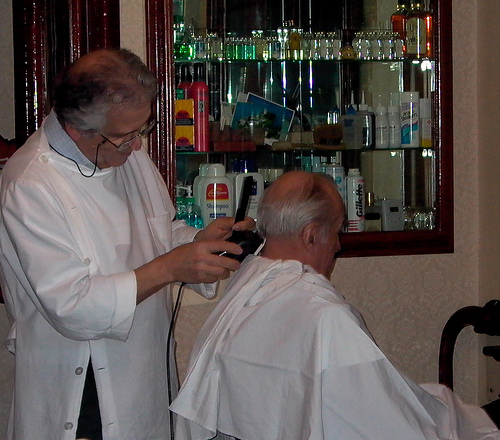

In [75]:
from IPython.display import display

# Provide the path to an image not used in training
test_image_path = r"C:\Users\swaya\Desktop\Timepass\python\IMAGE_WORD\flickr30k_images\69854977.jpg"

# Define the same transformations used during training
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Generate the caption
generated_caption = generate_caption(
    test_image_path,
    encoder,
    decoder,
    vocab,
    image_transforms,
    device
)

# --- See the results ---
print("Generated Caption:", generated_caption)
display(Image.open(test_image_path))